In [1]:
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import tensorflow as tf
import tensorboard as tb

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models,layers, Input, optimizers, initializers, regularizers, metrics
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,  EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [4]:
import os
from glob import glob
import PIL
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import math
import keras
import cv2

from os import listdir
from os.path import isfile, join
import random
import shutil

Using TensorFlow backend.


In [5]:
print(tf.__version__)

1.15.0


In [6]:
#gpu
# config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allow_growth = True
# sess =tf.compat.v1.Session(config=config)

In [7]:
os.getcwd()

'/home/caitech/Desktop/yujung'

# train / test 폴더로 이미지 나누기

In [8]:
# os.getcwd()
# os.chdir("./dataset")
# train_dir = os.path.join('/home/caitech/Desktop/yujung/dataset/train/')
# test_dir = os.path.join('/home/caitech/Desktop/yujung/dataset/test/')
train_dir = os.path.join('/home/caitech/Desktop/yujung/train/')
test_dir = os.path.join('/home/caitech/Desktop/yujung/test/')

In [ ]:
#pip install opencv-python
#import tensorflow as tf

In [ ]:
img = Image.open('/home/caitech/Desktop/yujung/0/PF132225.jpg')

In [ ]:
os.getcwd()

In [9]:
#test셋과 train셋으로 데이터 나눔

renew_database = 1
#파일 처리 - error예방
if(renew_database):
    if os.path.exists('train'):
        shutil.rmtree('train')
    if os.path.exists('test'):
        shutil.rmtree('test')
    if not os.path.exists('train'):
        os.mkdir('train')
    if not os.path.exists('test'):
        os.mkdir('test')



    rate=0.1 #분할 비율
    
    for root_dir in ['0', '1']:
        list_file = os.listdir(root_dir)
        picknumber=int(len(list_file)*rate) #test이미지 개수
        test_pic = random.sample(list_file, picknumber) #test중애서 랜덤으로 뽑기
        os.mkdir('train/'+root_dir)
        os.mkdir('test/'+root_dir)
        for item in list_file:
            if item in test_pic:
                shutil.copy(root_dir+'/'+item,'test/'+root_dir+'/'+item)
            else:  #나머지는 train
                shutil.copy(root_dir+'/'+item,'train/'+root_dir+'/'+item)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# VGG16

In [11]:
IMAGE_SIZE = 224

In [12]:
#데이터를 읽고 이미지를 한번에 넣은 개수_train
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),batch_size = 20,class_mode='binary')

Found 1380 images belonging to 2 classes.


In [13]:
#데이터를 읽고 이미지를 한번에 넣은 개수_validation
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),batch_size = 10, class_mode='binary')

Found 152 images belonging to 2 classes.


In [14]:
#vgg model생성
pre_trained_vgg = VGG16(weights = 'imagenet',include_top = False,input_shape = (224,224,3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
pre_trained_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
for layer in pre_trained_vgg.layers:
    layer.trainable = False

In [17]:
vgg_model = tf.keras.Sequential()
vgg_model.add(pre_trained_vgg)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(1024,activation = 'relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(layers.Dense(512,activation = 'relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(layers.Dense(256,activation = 'relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(layers.Dense(2,activation = 'softmax'))

vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [18]:
early_stopping = EarlyStopping(patience = 10)

In [19]:
vgg_model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [20]:
history_vgg = vgg_model.fit_generator(
        train_generator,
        steps_per_epoch=70,
        epochs=50,
        validation_data=test_generator,
        validation_steps= 16,
        callbacks = [early_stopping])

Epoch 1/50
70/70 [==============================] - 13s 191ms/step - loss: 3.4087 - acc: 0.5686 - val_loss: 0.6604 - val_acc: 0.6776
Epoch 2/50
70/70 [==============================] - 10s 142ms/step - loss: 0.9641 - acc: 0.5929 - val_loss: 0.6305 - val_acc: 0.6776
Epoch 3/50
70/70 [==============================] - 10s 145ms/step - loss: 0.7043 - acc: 0.6293 - val_loss: 0.6337 - val_acc: 0.6711
Epoch 4/50
70/70 [==============================] - 9s 134ms/step - loss: 0.6696 - acc: 0.6486 - val_loss: 0.6187 - val_acc: 0.6776
Epoch 5/50
70/70 [==============================] - 10s 146ms/step - loss: 0.6518 - acc: 0.6564 - val_loss: 0.6516 - val_acc: 0.6776
Epoch 6/50
70/70 [==============================] - 9s 132ms/step - loss: 0.6263 - acc: 0.6686 - val_loss: 0.6480 - val_acc: 0.6776
Epoch 7/50
70/70 [==============================] - 10s 139ms/step - loss: 0.6277 - acc: 0.6836 - val_loss: 0.6333 - val_acc: 0.6711
Epoch 8/50
70/70 [==============================] - 10s 142ms/step - lo

In [21]:
scores = vgg_model.evaluate_generator(test_generator, steps=16)

In [22]:
scores

[1.09917596320156, 0.67763156]

In [23]:
#Confution Matrix and Classification Report
#Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
Y_pred = vgg_model.predict_generator(test_generator, 16)
y_pred = np.argmax(Y_pred, axis=1)

In [24]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [25]:
len(y_pred)

152

In [26]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')

Confusion Matrix
[[ 7 42]
 [13 90]]
Classification Report


In [27]:
#target_names = ['Cats', 'Dogs', 'Horse']
target_names = ['0', '1']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.35      0.14      0.20        49
           1       0.68      0.87      0.77       103

    accuracy                           0.64       152
   macro avg       0.52      0.51      0.48       152
weighted avg       0.57      0.64      0.58       152



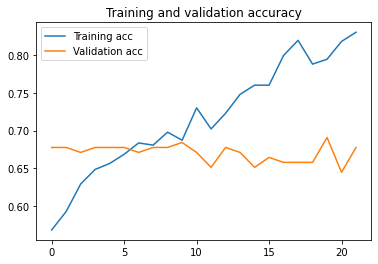

In [28]:
epochs = range(len(history_vgg.history['acc']))

plt.plot(epochs,history_vgg.history['acc'], label='Training acc')
plt.plot(epochs, history_vgg.history['val_acc'],label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

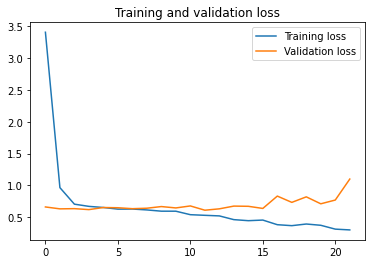

In [29]:
#plt.figure()
plt.plot(epochs,history_vgg.history['loss'],label='Training loss')
plt.plot(epochs,history_vgg.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

#plt.show()

# Inception-v3

In [30]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop

In [31]:
#크기조절
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [32]:
IMAGE_SIZE = 299

In [33]:
#데이터를 읽고 이미지를 한번에 넣은 개수_train
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=20,
                                                        class_mode='binary')

Found 1380 images belonging to 2 classes.


In [34]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (IMAGE_SIZE,IMAGE_SIZE),batch_size = 10,
                                                 class_mode = 'binary')

Found 152 images belonging to 2 classes.


In [35]:
pre_inceptionV3 = InceptionV3(weights = 'imagenet',include_top=False,input_shape = (299,299,3))

In [36]:
pre_inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [37]:
v3_model = tf.keras.Sequential()
v3_model.add(pre_inceptionV3)
v3_model.add(layers.GlobalAveragePooling2D())
v3_model.add(layers.Dense(2,activation = 'softmax'))

In [38]:
v3_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [39]:
from tensorflow.keras.optimizers import RMSprop

In [40]:
for layer in pre_inceptionV3.layers:
    layer.trainable = False

In [ ]:
#pre_inceptionV3.trainable = False

In [41]:
early_stopping = EarlyStopping(patience =10)

In [42]:
v3_model.compile(loss='sparse_categorical_crossentropy', 
              #optimizer='adam',
              optimizer = 'RMSprop',
              metrics=['accuracy'],
             )

In [43]:
history_inceptionv3= v3_model.fit_generator(
        train_generator,
        steps_per_epoch=70,
        epochs=50,
        validation_data=test_generator,
        validation_steps= 16,
        callbacks = [early_stopping])

Epoch 1/50
70/70 [==============================] - 15s 221ms/step - loss: 0.7019 - acc: 0.6129 - val_loss: 0.6994 - val_acc: 0.6382
Epoch 2/50
70/70 [==============================] - 11s 154ms/step - loss: 0.6420 - acc: 0.6536 - val_loss: 0.6837 - val_acc: 0.6711
Epoch 3/50
70/70 [==============================] - 10s 145ms/step - loss: 0.6334 - acc: 0.6536 - val_loss: 0.7038 - val_acc: 0.6053
Epoch 4/50
70/70 [==============================] - 11s 153ms/step - loss: 0.6001 - acc: 0.6871 - val_loss: 0.7874 - val_acc: 0.5132
Epoch 5/50
70/70 [==============================] - 11s 154ms/step - loss: 0.6097 - acc: 0.6821 - val_loss: 0.7133 - val_acc: 0.5855
Epoch 6/50
70/70 [==============================] - 10s 148ms/step - loss: 0.5839 - acc: 0.7064 - val_loss: 0.7481 - val_acc: 0.6776
Epoch 7/50
70/70 [==============================] - 10s 146ms/step - loss: 0.5938 - acc: 0.6721 - val_loss: 0.7222 - val_acc: 0.5789
Epoch 8/50
70/70 [==============================] - 10s 147ms/step - 

In [44]:
v3_scores = v3_model.evaluate_generator(test_generator, steps=16)

In [45]:
v3_scores

[0.8927066326141357, 0.5]

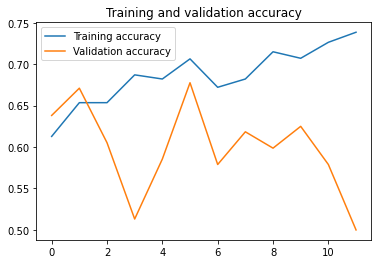

In [46]:
epochs = range(len(history_inceptionv3.history['acc']))
plt.plot(epochs, history_inceptionv3.history['acc'],label = 'Training accuracy')
plt.plot(epochs,history_inceptionv3.history['val_acc'],label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


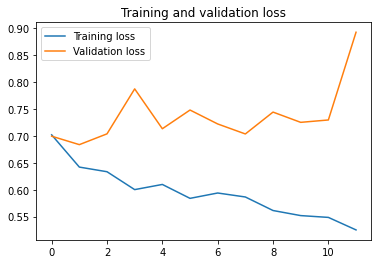

In [47]:
plt.plot(epochs, history_inceptionv3.history['loss'],label='Training loss')
plt.plot(epochs,history_inceptionv3.history['val_loss'],label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [48]:
Y_pred_v3 = v3_model.predict_generator(test_generator, 16)
y_pred_v3 = np.argmax(Y_pred_v3, axis=1)

In [49]:
y_pred_v3

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])

In [50]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred_v3))
print('Classification Report')

Confusion Matrix
[[27 22]
 [64 39]]
Classification Report


In [51]:
#target_names = ['Cats', 'Dogs', 'Horse']
target_names = ['0', '1']
print(classification_report(test_generator.classes, y_pred_v3, target_names=target_names))

              precision    recall  f1-score   support

           0       0.30      0.55      0.39        49
           1       0.64      0.38      0.48       103

    accuracy                           0.43       152
   macro avg       0.47      0.46      0.43       152
weighted avg       0.53      0.43      0.45       152



In [ ]:
# inceptionV3_model.evaluate(test_x,test_y,verbose =1)

# ResNet

In [52]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [53]:
IMAGE_SIZE = 224

In [54]:
#데이터를 읽고 이미지를 한번에 넣은 개수_train
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=20,
                                                        class_mode='binary')

Found 1380 images belonging to 2 classes.


In [55]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (IMAGE_SIZE,IMAGE_SIZE),batch_size = 10,
                                                 class_mode = 'binary')

Found 152 images belonging to 2 classes.


In [56]:
pre_resnet = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

In [57]:
for layer in pre_resnet.layers:
    layer.trainable = False

In [58]:
#pre_resnet.trainable = False
pre_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [59]:
r_model = tf.keras.Sequential()
r_model.add(pre_resnet)
r_model.add(layers.GlobalAveragePooling2D())
r_model.add(layers.Dense(2,activation = 'softmax'))

In [60]:
r_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [61]:
# from tensorflow.keras.callbacks import EarlyStopping

In [62]:
early_stopping = EarlyStopping(patience = 10)

In [63]:
r_model.compile(loss='sparse_categorical_crossentropy', 
              #optimizer='adam',
              optimizer = 'RMSprop',
              metrics=['accuracy'],
             )

In [64]:
history_resnet = r_model.fit_generator(train_generator,
                                       steps_per_epoch=70,
                                       epochs=50,
                                       validation_data=test_generator,
                                       validation_steps= 16,
                                      callbacks = [early_stopping])

Epoch 1/50
70/70 [==============================] - 13s 181ms/step - loss: 0.7893 - acc: 0.6071 - val_loss: 0.9398 - val_acc: 0.3224
Epoch 2/50
70/70 [==============================] - 9s 132ms/step - loss: 0.6756 - acc: 0.6450 - val_loss: 1.0541 - val_acc: 0.3224
Epoch 3/50
70/70 [==============================] - 10s 146ms/step - loss: 0.6639 - acc: 0.6686 - val_loss: 1.3772 - val_acc: 0.3224
Epoch 4/50
70/70 [==============================] - 10s 139ms/step - loss: 0.5903 - acc: 0.7100 - val_loss: 1.8864 - val_acc: 0.3224
Epoch 5/50
70/70 [==============================] - 9s 135ms/step - loss: 0.5916 - acc: 0.6886 - val_loss: 1.7322 - val_acc: 0.3224
Epoch 6/50
70/70 [==============================] - 10s 147ms/step - loss: 0.5799 - acc: 0.7164 - val_loss: 1.9410 - val_acc: 0.3224
Epoch 7/50
70/70 [==============================] - 9s 132ms/step - loss: 0.5702 - acc: 0.7129 - val_loss: 1.9052 - val_acc: 0.3224
Epoch 8/50
70/70 [==============================] - 10s 139ms/step - los

In [76]:
scores_resnet = r_model.evaluate_generator(test_generator,steps = 16)

In [72]:
import pandas as pd

In [73]:
hist_df_resnet = pd.DataFrame(history_resnet.history) 

In [75]:
hist_df_resnet.to_csv('history_resnet.csv')

In [80]:
r_model.save_weights('./checkpoints/my_checkpoint')

In [81]:
# 새로운 모델 객체를 만듭니다
model = create_model()

NameError: name 'create_model' is not defined

In [ ]:
# 가중치를 복원합니다
model.load_weights('./checkpoints/my_checkpoint')

# 모델을 평가합니다
loss,acc = model.evaluate(test_images,  test_labels, verbose=2)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

In [77]:
scores_df_resnet = pd.DataFrame(scores_resnet)

In [79]:
scores_df_resnet.to_csv('scores_resnet.csv')

In [74]:
# hist_csv_file_resnet = 'history_resnet.csv'
# with open(hist_csv_file_resnet, mode='w') as f:
#     hist_df_resnet.to_csv(f)

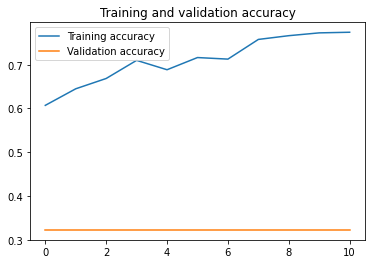

In [66]:
epochs = range(len(history_resnet.history['acc']))
plt.plot(epochs, history_resnet.history['acc'],label = 'Training accuracy')
plt.plot(epochs,history_resnet.history['val_acc'],label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

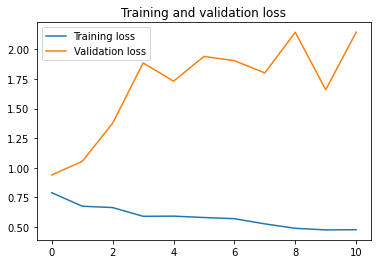

In [67]:
plt.plot(epochs, history_resnet.history['loss'],label='Training loss')
plt.plot(epochs,history_resnet.history['val_loss'],label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [68]:
Y_pred_resnet = r_model.predict_generator(test_generator, 16)
y_pred_resnet = np.argmax(Y_pred_resnet, axis=1)

In [69]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred_resnet))
print('Classification Report')

Confusion Matrix
[[ 49   0]
 [103   0]]
Classification Report


In [70]:
target_names = ['0', '1']
print(classification_report(test_generator.classes, y_pred_resnet, target_names=target_names))

              precision    recall  f1-score   support

           0       0.32      1.00      0.49        49
           1       0.00      0.00      0.00       103

    accuracy                           0.32       152
   macro avg       0.16      0.50      0.24       152
weighted avg       0.10      0.32      0.16       152



/home/caitech/anaconda3/envs/yu4/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


모델들 함수로 만들기

https://www.programcreek.com/python/example/89688/keras.layers.GlobalAveragePooling2D

fit_generator와 evaluate_generator 코드

https://tykimos.tistory.com/14

결과 참고

https://tykimos.github.io/2017/03/08/CNN_Getting_Started/

In [ ]:
#글로벌 공간 평균값 폴링 레이어를 더합니다. 
x_res  = pre_resnet.output
x_res = GlobalAveragePooling2D()(x_res)

In [ ]:
#완전 연결 레이어 더하기
x_res = Dense(1024,activation = 'relu')(x_res)
#로지스틱레이어 더하기
predictions = Dense(2,activation = 'softmax')(x_res)

In [ ]:
#학습할 모델
resnet_model = Model(inputs = pre_resnet.input,outputs = predictions)

In [ ]:
resnet_model.summary()

In [ ]:
epochs = range(len(history_resnet.history['accuracy']))
plt.plot(epochs , history_resnet.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs , history_resnet.history['val_accuracy'],label = 'Validation Accuracy')
plt.legend()

In [ ]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# import keras

In [ ]:
# %matplotlib inline

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
# from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# #층 설정 및 활성함수
# model = keras.Sequential([
#         Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         Flatten(),
#         Dropout(0.25),
#         Dense(128, activation='relu'),

#         Dropout(0.5),
#         Dense(2, activation='softmax')
#         ])

In [ ]:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# import os
# os.environ["PATH"] += os.pathsep + './Graphviz2.38/bin/'

In [ ]:
# os.environ["PATH"] += os.pathsep + './Graphviz2.38/bin/'dd

In [ ]:
import mtcnn

In [ ]:
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
os.getcwd()

In [ ]:
img = plt.imread('/home/caitech/Desktop/yujung/0/PF154694.jpg')

In [ ]:
 plt.imshow(img)

In [ ]:
detector = MTCNN()

In [ ]:
faces = detector.detect_faces(img)

In [ ]:
for face in faces:
    print(face)

In [ ]:
len(faces)

In [ ]:
path = '/home/caitech/Desktop/yujung/0/'   #PF154694.jpg'

In [ ]:
# def draw_rectangles(filename, result_list):
#     path = '/home/caitech/Desktop/yujung/0/'
# #     # load image
# #     image = plt.imread(filename)
# #     #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# #     # plot the image's data
# #     plt.imshow(image)
#     image = Image.open(path+filename)
#     # get image axes
#     ax = plt.gca() # Get Current Axes (not a typo) method, an object that has two Axis objects (x-axis and y-axis)
#     # plot each box
#     for result in result_list:
#         # coordinates
#         x, y, width, height = result['box']
#         # The shape
#         rectangle = Rectangle((x, y), width, height, fill=False, color='yellow')
#         #cv2.rectangle(image,(x,y),(x+width,y+height),(255,0,0),2)
#         # draw them
#          ax.add_patch(rectangle)
#     # Display plot
#     plt.show()
# #      plt.figure(figsize=(12,8))
# #      plt.imshow(image, cmap='gray')
# #      plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# #      plt.show()

In [ ]:
filename = 'PF154694.jpg'

In [ ]:
draw_rectangles(filename, faces)

In [ ]:
for result in faces:
    x,y,w.h = result['box']
    #cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

In [ ]:
result['box']

In [ ]:
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = plt.imread(filename)
	# plot the image
	plt.imshow(data)
	# get the context for drawing boxes
	ax = plt.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='yellow')
		# draw the box
		ax.add_patch(rect)
	# show the plot
	plt.show()

In [ ]:
 
filename = '/home/caitech/Desktop/yujung/0/PF154694.jpg'
# load image from file
pixels = plt.imread(filename)
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_image_with_boxes(filename, faces)

In [ ]:
files_0 = os.listdir("/home/caitech/Desktop/yujung/0")

In [ ]:
path_0 =os.listdir('/home/caitech/Desktop/yujung/0/')

In [ ]:
len(path_0)

In [ ]:
path = '/home/caitech/Desktop/yujung/0/'
detector = MTCNN()
face_list = []

In [ ]:
# for file in files_0:
#     img = plt.imread(path+file)
#     faces = detector.detect_faces(img)
#     face_list.append(len(faces))